In [0]:
%cd drive/My\ Drive/image-super-resolution

**Install required packages** 

In [0]:
!pip install folium==0.2.1
!pip install imgaug==0.2.6

In [0]:
!pip install ISR

# Train


## Get the training data
Geting data to train the model. The div2k dataset linked here is for a scaling factor of 2. 


In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

Extracting the training and validation datasets

In [0]:
!mkdir div2k
!unzip -q DIV2K_valid_LR_bicubic_X2.zip -d div2k
!unzip -q DIV2K_train_LR_bicubic_X2.zip -d div2k
!unzip -q DIV2K_train_HR.zip -d div2k
!unzip -q DIV2K_valid_HR.zip -d div2k

## Create the models
Importing the models from the ISR package and create

- a RRDN super scaling network
- a discriminator network for GANs training
- a VGG19 feature extractor to train with a perceptual loss function

Carefully selecting
- 'x': this is the upscaling factor (2 by default)
- 'layers_to_extract': these are the layers from the VGG19 that will be used in
 the perceptual loss (leave the default if you're not familiar with it)
- 'lr_patch_size': this is the size of the patches that will be extracted from 
the LR images and fed to the ISR network during training time

We can play around with the other architecture parameters

In [0]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

In [0]:
lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 2
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

## Give the models to the Trainer
The Trainer object will combine the networks, manage your training data and
 keep you up-to-date with the training progress through Tensorboard and the 
 command line.

Here we do not use  the pixel-wise MSE but only the perceptual loss by 
specifying the respective weights in `loss_weights`

In [0]:
from ISR.train import Trainer
loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
} 

log_dirs = {'logs': './logs', 'weights': './weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir='div2k/DIV2K_train_LR_bicubic/X2/',
    hr_train_dir='div2k/DIV2K_train_HR/',
    lr_valid_dir='div2k/DIV2K_train_LR_bicubic/X2/',
    hr_valid_dir='div2k/DIV2K_train_HR/',
    loss_weights=loss_weights,
    learning_rate=learning_rate,
    flatness=flatness,
    dataname='div2k',
    log_dirs=log_dirs,
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)


**Choosing** epoch number, steps and batch size and start training

In [0]:
trainer.train(
    epochs=1,
    steps_per_epoch=20,
    batch_size=4,
    monitored_metrics={'val_PSNR_Y': 'max'}
)


Training details:
  training_parameters: 
    metrics: {'generator': <function PSNR_Y at 0x7f75e83a4950>}
    losses: {'generator': 'mae', 'discriminator': 'binary_crossentropy', 'feature_extractor': 'mse'}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    n_validation: 40
    dataname: div2k
    fallback_save_every_n_epochs: 2
    log_dirs: {'logs': './logs', 'weights': './weights'}
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    hr_valid_dir: div2k/DIV2K_train_HR/
    lr_valid_dir: div2k/DIV2K_train_LR_bicubic/X2/
    hr_train_dir: div2k/DIV2K_train_HR/
    lr_train_dir: div2k/DIV2K_train_LR_bicubic/X2/
    lr_patch_size: 40
    steps_per_epoch: 20
    batch_size: 4
    starting_epoch: 0
  generator: 
    name: rrdn
    parameters: {'C': 4, 'D': 3,

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 20/20 [12:55<00:00, 38.05s/it]
Epoch 0 took      775.5s


160/160 [==============================] - 289s 2s/step


val_PSNR_Y is NOT among the model metrics, removing it.
{'val_loss': 0.9109238140285015, 'val_generator_loss': 0.3806507588829845, 'val_discriminator_loss': 0.6993054270744323, 'val_feature_extractor_loss': 17.903962839394808, 'val_generator_PSNR_Y': 8.976044297218323, 'train_d_real_loss': 0.015169758, 'train_d_real_acc': 1.0, 'train_d_fake_loss': 0.12120165, 'train_d_fake_acc': 0.984375, 'train_loss': 0.93584913, 'train_generator_loss': 0.65396327, 'train_discriminator_loss': 3.4905734, 'train_feature_extractor_loss': 17.746695, 'train_generator_PSNR_Y': 4.1453223}


In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import io
import seaborn as sns
sns.set()
df= pd.read_csv('test.csv')

In [0]:
df.head()

,train_d_real_loss,train_d_real_acc,train_d_fake_loss,train_d_fake_acc,train_loss,train_generator_loss,train_discriminator_loss,train_feature_extractor_loss,train_generator_PSNR_Y
0,1.008249,0.295625,0.662678,0.661875,0.587981,0.353752,1.621550,11.624330,7.585315
1,0.954688,0.533125,0.656268,0.606875,2.286234,0.482036,1.892887,45.801735,6.273267
2,1.023664,0.442500,0.620428,0.706875,2.144126,0.371839,1.829795,43.312344,8.616900
3,1.166968,0.545000,0.943410,0.519375,1.298555,0.495433,1.522776,26.584316,5.972748
4,0.315486,0.915000,1.377564,0.268125,1.539065,0.561159,2.436161,30.135712,4.739633


In [0]:
df.info()

In [0]:
df.columns

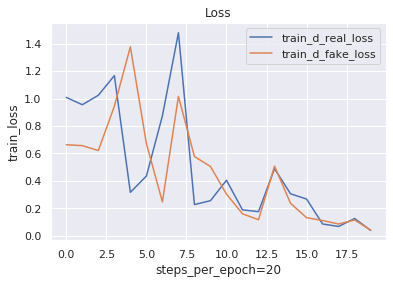

In [0]:
plt.xlabel('steps_per_epoch=20')
plt.ylabel('train_loss') 
plt.title('Loss')
plt.plot(df['  train_d_real_loss'])
plt.plot(df[' train_d_fake_loss'])
plt.legend(['train_d_real_loss','train_d_fake_loss'],loc='upper right');

plt.show()

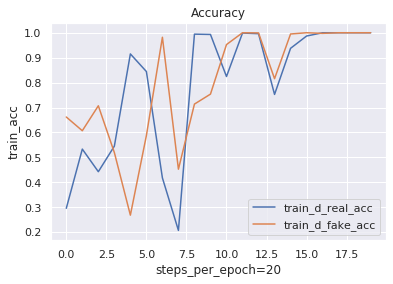

In [0]:
plt.xlabel('steps_per_epoch=20')
plt.ylabel('train_acc') 
plt.title('Accuracy')
plt.plot(df['train_d_real_acc'])
plt.plot(df[' train_d_fake_acc'])
plt.legend(['train_d_real_acc','train_d_fake_acc'],loc='lower right');
plt.show()

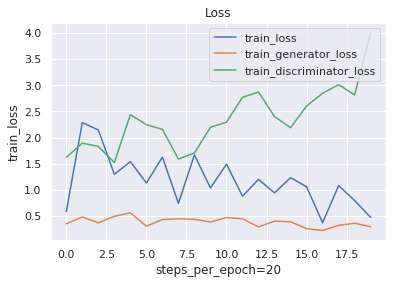

In [0]:
plt.xlabel('steps_per_epoch=20')
plt.ylabel('train_loss') 
plt.title('Loss')
plt.plot(df[' train_loss'])
plt.plot(df[' train_generator_loss'])
plt.plot(df[' train_discriminator_loss'])
plt.legend(['train_loss','train_generator_loss','train_discriminator_loss'],loc='upper right');
plt.show()

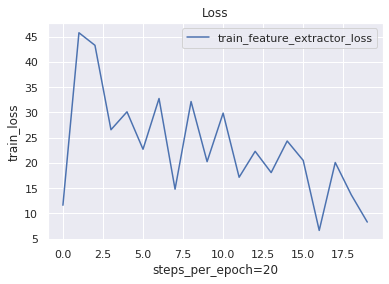

In [0]:
plt.xlabel('steps_per_epoch=20')
plt.ylabel('train_loss') 
plt.title('Loss')
plt.plot(df[' train_feature_extractor_loss'])
plt.legend(['train_feature_extractor_loss'],loc='upper right');
plt.show()

# Downloading testing datasets:

In [0]:
!wget http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip 

In [0]:
!mkdir SR
!unzip -q SR_testing_datasets.zip -d SR

In [0]:
!ls

In [0]:
!python tests/predict/test_predict.py

# Predict

## Get the pre-trained weights and data

Get the weights with



In [0]:
%cd /content/drive/My\ Drive/image-super-resolution

/content/drive/My Drive/image-super-resolution


In [0]:
!wget https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/
--sample_weights/rdn-C6-D20-G64-G064-x2/ArtefactCancelling/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5
!wget https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/
--sample_weights/rdn-C6-D20-G64-G064-x2/PSNR-driven/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5
!wget https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/
--sample_weights/rdn-C3-D10-G64-G064-x2/PSNR-driven/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5
!wget https://media.githubusercontent.com/media/idealo/image-super-resolution/master/weights/
--sample_weights/rrdn-C4-D3-G32-G032-T10-x4/Perceptual/rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5
#!mkdir weights
#!mv *.hdf5 weights

In [0]:
% cd weights

/content/drive/My Drive/image-super-resolution/weights


Download a sample image, in this case

In [0]:
!wget http://images.math.cnrs.fr/IMG/png/section8-image.png
!mkdir -p data/input/test_images
!mv *.png data/input/test_images

Load the image with PIL

In [0]:
import numpy as np
from PIL import Image

img = Image.open('data/input/test_images/section8-image.png')
img

## Get predictions

### Create the model and run prediction
Create the RDN model, for which we provide pre-trained weights, and load them

Choose amongst the available model weights, compare the output if you wish.



In [0]:
from ISR.models import RDN, RRDN

#### RRDN GANS model

In [0]:
#rrdn = RRDN(arch_params={'C': 4, 'D':3, 'G':32, 'G0':32, 'x':4, 'T': 10})
#rrdn.model.load_weights('weights/rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5')

In [0]:
rrdn = RRDN(arch_params={'C':4, 'D':3, 'G':32, 'G0':32, 'T':10, 'x':4})
rrdn.model.load_weights('weights/rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5')

#### Large RDN model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')

#### Small RDN model

In [0]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')

#### Large RDN noise cancelling, detail enchancing model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')

#### Run prediction

In [0]:
sr_img = rdn.predict(np.array(img))
Image.fromarray(sr_img)

In [0]:
sr_img = rdn.predict(np.array(img))
Image.fromarray(sr_img)

### Usecase: upscaling noisy images

Now, for science, let's make it harder for the networks.

We compress the image into the jpeg format to introduce compression artefact and lose some information.

We will compare:
- the baseline bicubic scaling
- the basic model - Add Hyperlink
- a model trained to remove noise using perceptual loss with deep features and GANs training

So let's first  compress the image

In [0]:
img.save('data/input/test_images/compressed.jpeg','JPEG', dpi=[300, 300], quality=50)
compressed_img = Image.open('data/input/test_images/compressed.jpeg')

compressed_img

(open the image in a new tab and zoom in to inspect it)

#### Baseline
Bicubic scaling

In [0]:
compressed_img.resize(size=(compressed_img.size[0]*2, compressed_img.size[1]*2), resample=Image.BICUBIC)

#### Large RDN model (PSNR trained)

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_PSNR_epoch086.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

#### Small RDN model  (PSNR trained)

In [0]:
rdn = RDN(arch_params={'C': 3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

#### Large RDN noise cancelling, detail enhancing model

In [0]:
rdn = RDN(arch_params={'C': 6, 'D':20, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights('weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')
sr_img = rdn.predict(np.array(compressed_img))
Image.fromarray(sr_img)

### Predictor Class
You can also use the predictor class to run the model on entire folders:

In [0]:
from ISR.predict import Predictor
!mkdir -p data/output
predictor = Predictor(input_dir='data/input/test_images/')
predictor.get_predictions(model=rdn, weights_path='weights/rdn-C6-D20-G64-G064-x2_ArtefactCancelling_epoch219.hdf5')